<a href="https://colab.research.google.com/github/indianspeedster/edu-ml/blob/main/intent_classification_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! wget https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data/master/Collected-Original-Data/paraphrases_and_intents_26k_normalised_all.csv -O intent_data.csv

--2023-06-12 17:36:16--  https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data/master/Collected-Original-Data/paraphrases_and_intents_26k_normalised_all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5151481 (4.9M) [text/plain]
Saving to: ‘intent_data.csv’

intent_data.csv     100%[===================>]   4.91M  --.-KB/s    in 0.08s   

2023-06-12 17:36:16 (59.4 MB/s) - ‘intent_data.csv’ saved [5151481/5151481]



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [50]:
dataframe = pd.read_csv("intent_data.csv", delimiter=';')

In [51]:
dataframe["merged"] = dataframe["scenario"] + "_" + dataframe["intent"]

In [52]:
labels = dataframe["merged"].value_counts().to_frame().reset_index()
labels.columns = ["name","count"]
labels

,name,count
0,music_play,1218
1,IOT_hue,1068
2,QA_factoid,973
3,calendar_set_event,959
4,email_query,887
...,...,...
59,audio_mute,192
60,QA_maths,189
61,alarm_query,186
62,datetime_convert,177


In [53]:
labels_included = labels["name"].head(10).to_list()
new_df = dataframe[["answer", "merged"]]
new_df = new_df[new_df["merged"].isin(labels_included)]
new_df.columns = ["speech_text","intent"]
le=LabelEncoder()
new_df['intent']=le.fit_transform(new_df['intent'])

In [12]:
tokenized = new_df.speech_text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

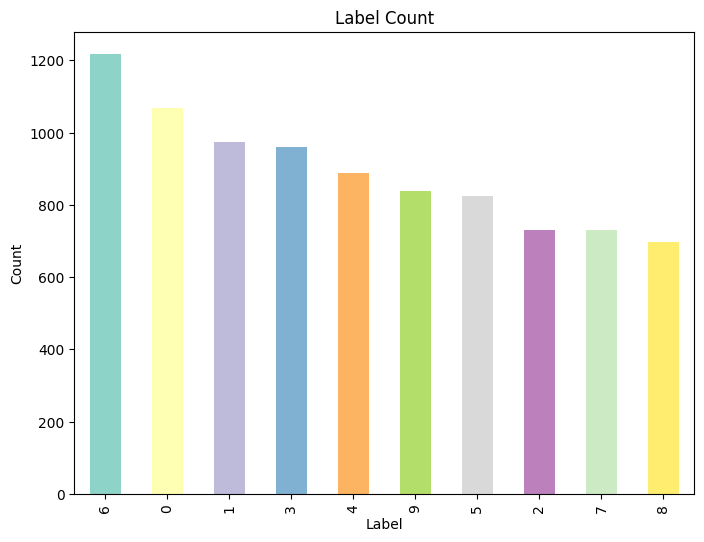

In [54]:
label_counts = new_df['intent'].value_counts()
num_labels = len(label_counts)
color_palette = plt.cm.get_cmap('Set3', num_labels)
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=color_palette(np.arange(num_labels)))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Count')
plt.show()

In [14]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
padded, padded.shape

(array([[  101, 19330,  2135, ...,     0,     0,     0],
        [  101,  3972, 12870, ...,     0,     0,     0],
        [  101, 19330,  2135, ...,     0,     0,     0],
        ...,
        [  101,  2097,  1045, ...,     0,     0,     0],
        [  101,  2323,  1045, ...,     0,     0,     0],
        [  101,  2079,  1045, ...,     0,     0,     0]]),
 (8924, 37))

In [15]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(8924, 37)

In [16]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [17]:
features = last_hidden_states[0][:,0,:].numpy()

In [32]:
train_features, test_features, train_labels, test_labels = train_test_split(features, new_df["intent"].to_numpy())

In [48]:
batch_size = 32  
shuffle = True
features_tensor = torch.tensor(train_features)
labels_tensor = torch.tensor(train_labels)
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
features_tensor_val = torch.tensor(test_features)
labels_tensor_val = torch.tensor(test_labels)
dataset_val = TensorDataset(features_tensor_val, labels_tensor_val)
evaluation_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [42]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [44]:
model = NeuralNetwork(train_features.shape[1], 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [47]:
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in evaluation_data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")

    model.train()

Epoch [1/1000], Accuracy: 34.69%
Epoch [2/1000], Accuracy: 34.69%
Epoch [3/1000], Accuracy: 34.74%
Epoch [4/1000], Accuracy: 34.74%
Epoch [5/1000], Accuracy: 34.78%
Epoch [6/1000], Accuracy: 34.83%
Epoch [7/1000], Accuracy: 34.84%
Epoch [8/1000], Accuracy: 34.83%
Epoch [9/1000], Accuracy: 34.83%
Epoch [10/1000], Accuracy: 34.84%
Epoch [11/1000], Accuracy: 34.86%
Epoch [12/1000], Accuracy: 34.86%
Epoch [13/1000], Accuracy: 34.86%
Epoch [14/1000], Accuracy: 34.90%
Epoch [15/1000], Accuracy: 34.92%
Epoch [16/1000], Accuracy: 34.96%
Epoch [17/1000], Accuracy: 35.20%
Epoch [18/1000], Accuracy: 35.62%
Epoch [19/1000], Accuracy: 36.14%
Epoch [20/1000], Accuracy: 36.53%
Epoch [21/1000], Accuracy: 37.01%
Epoch [22/1000], Accuracy: 37.56%
Epoch [23/1000], Accuracy: 38.43%
Epoch [24/1000], Accuracy: 39.09%
Epoch [25/1000], Accuracy: 39.40%
Epoch [26/1000], Accuracy: 39.68%
Epoch [27/1000], Accuracy: 40.13%
Epoch [28/1000], Accuracy: 40.49%
Epoch [29/1000], Accuracy: 40.71%
Epoch [30/1000], Accura